In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [2]:
dataset_path = 'regione-toscana/dataset-dirigenti.pkl'

with open(dataset_path, 'rb') as f:
    samples, labels = pickle.load(f)

### Transform it in a dataset

In [3]:
samples[:5]

array([ "DGR 968/07 e s.m.i. Accreditamento degli organismi formativi. Rilascio dell'accreditamento all'organismo formativo Bioscience Research Center - cod. GR1035.",
       'Nomina Commissione d’esame per il percorso formativo “Formazione obbligatoria per utilizzatori professionali di prodotti fitosanitari”, MATRICOLA N. 2016SI0046',
       "Nomina della Commissione d'esame matricola 2016PI0301. Agenzia Formativa Cescot",
       'Progetti formativi per drop-out a.s.f. 2015-2016. Integrazione impegno per progetto "Figaro - Operatore del benessere (acconciatura)"',
       'REG (CE) 1080/2006-Por Creo Fesr 2007-2013-Linea di intevento 5.1.d-Chiusura attività'],
      dtype='<U961')

In [4]:
labels[:5]

array(['50125', '50125', '50125', '50125', '50125'],
      dtype='<U5')

In [5]:
samples = np.array(samples)
labels = np.array(labels)

## Train and Test Set

Normally we split the dataset into:
- 80% for training (of which 10% for validation)
- 20% for testing

In [6]:
samples.shape

(147463,)

### Shuffle Data

In [7]:
indices = list(range(len(samples)))
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

In [8]:
labels[:5]

array(['01946', '50125', '50006', '50119', '50102'],
      dtype='<U5')

## Tokenize the Dataset

In [9]:
max_features = 10000

In [10]:
from keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words=max_features, oov_token='UNK')
tokenizer.fit_on_texts(samples)

In [12]:
sequences = tokenizer.texts_to_sequences(samples)

In [13]:
for s in sequences[:2]:
    print(s) 

[7, 6, 611, 327, 96, 4, 79, 56, 1, 905, 2, 131, 22, 1936, 2, 13, 4848, 6156, 59, 100, 15, 2, 20, 574, 307, 769, 84, 428]
[102, 475, 113, 2, 19, 97, 51, 110, 53, 385, 297, 650, 2940, 621, 358, 9994, 112, 303]


Convert labels to sequences

In [14]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [15]:
list(labels_to_index.items())[:5]

[('02090', 0), ('50202', 1), ('50079', 2), ('01937', 3), ('01928', 4)]

In [16]:
len(labels_to_index)

32

In [17]:
encoded_labels = [labels_to_index[l] for l in labels]

In [18]:
encoded_labels[:10]

[20, 17, 23, 30, 19, 21, 12, 7, 5, 13]

### Split the dataset

In [19]:
training_size = math.trunc(len(sequences) * 0.8)
test_size = len(sequences)

In [20]:
train_data = sequences[:training_size]
train_labels = encoded_labels[:training_size]

test_data = sequences[training_size:]
test_labels = encoded_labels[training_size:] 

### Preparing Data

- for the input data we pad the sequence to a max length in order to make uniform the sequences.
- for the labels we continue with one-hot encoding


In [21]:
from keras.preprocessing import sequence

In [22]:
print('max length of objects {}'.format(max(map(len, train_data))))

max length of objects 147


#### Maximum Sequence Length

for initial test we use the first 100 words

In [64]:
maxlen = 100

In [130]:
x_train_seq = sequence.pad_sequences(train_data, maxlen=maxlen)
x_test_seq = sequence.pad_sequences(test_data, maxlen=maxlen)

In [66]:
x_train_seq.shape

(117970, 100)

One-hot encoding for input

In [50]:
def vectorize_sequences(sequences, dimension=10000):
    data = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        data[i,sequence] = 1.
    return data

In [27]:
x_train = vectorize_sequences(train_data)
y_train = vectorize_sequences(test_data)

One hot encoding for the labels

In [28]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [29]:
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [30]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

## The Effects of Word Embeddings

Before using a word embedding as a layer in our network let evaluate the effect of embeddings by training a simple classifier that has it as only layer.

In [67]:
def build_model_only_embeddings(embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    model.compile(optimizer=optimizers.Adam(), 
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    return model

In [68]:
model_only_embed_small = build_model_only_embeddings(32)
model_only_embed_medium = build_model_only_embeddings(128)
model_only_embed_large = build_model_only_embeddings(256)

In [69]:
history_embed_small = model_only_embed_small.fit(x=x_train_seq, y=y_train,  validation_split=0.2,
                   epochs=10, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/10
94376/94376 [==============================] - 2s 17us/step - loss: 2.3680 - acc: 0.3597 - val_loss: 1.5435 - val_acc: 0.5585
Epoch 2/10
94376/94376 [==============================] - 1s 14us/step - loss: 1.2031 - acc: 0.6486 - val_loss: 1.0628 - val_acc: 0.6725
Epoch 3/10
94376/94376 [==============================] - 1s 13us/step - loss: 0.8618 - acc: 0.7382 - val_loss: 0.8973 - val_acc: 0.7106
Epoch 4/10
94376/94376 [==============================] - 1s 13us/step - loss: 0.6937 - acc: 0.7869 - val_loss: 0.8134 - val_acc: 0.7323
Epoch 5/10
94376/94376 [==============================] - 1s 14us/step - loss: 0.5835 - acc: 0.8220 - val_loss: 0.7688 - val_acc: 0.7432
Epoch 6/10
94376/94376 [==============================] - 1s 13us/step - loss: 0.5026 - acc: 0.8481 - val_loss: 0.7405 - val_acc: 0.7520
Epoch 7/10
94376/94376 [==============================] - 1s 13us/step - loss: 0.4387 - acc: 0.8694 - val_loss: 0.7242 - val_acc

In [70]:
history_embed_medium = model_only_embed_medium.fit(x=x_train_seq, y=y_train,  validation_split=0.2,
                   epochs=10, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/10
94376/94376 [==============================] - 3s 30us/step - loss: 1.9124 - acc: 0.4728 - val_loss: 1.1020 - val_acc: 0.6682
Epoch 2/10
94376/94376 [==============================] - 3s 27us/step - loss: 0.8212 - acc: 0.7495 - val_loss: 0.8116 - val_acc: 0.7354
Epoch 3/10
94376/94376 [==============================] - 3s 27us/step - loss: 0.5533 - acc: 0.8334 - val_loss: 0.7312 - val_acc: 0.7568
Epoch 4/10
94376/94376 [==============================] - 3s 27us/step - loss: 0.4039 - acc: 0.8836 - val_loss: 0.6969 - val_acc: 0.7660
Epoch 5/10
94376/94376 [==============================] - 3s 29us/step - loss: 0.3017 - acc: 0.9183 - val_loss: 0.6966 - val_acc: 0.7674
Epoch 6/10
94376/94376 [==============================] - 3s 28us/step - loss: 0.2286 - acc: 0.9428 - val_loss: 0.7007 - val_acc: 0.7703
Epoch 7/10
94376/94376 [==============================] - 3s 28us/step - loss: 0.1752 - acc: 0.9590 - val_loss: 0.7178 - val_acc

In [71]:
history_embed_large = model_only_embed_large.fit(x=x_train_seq, y=y_train,  validation_split=0.2,
                   epochs=10, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/10
94376/94376 [==============================] - 5s 51us/step - loss: 1.7050 - acc: 0.5218 - val_loss: 0.9579 - val_acc: 0.6987
Epoch 2/10
94376/94376 [==============================] - 5s 48us/step - loss: 0.6840 - acc: 0.7898 - val_loss: 0.7440 - val_acc: 0.7513
Epoch 3/10
94376/94376 [==============================] - 5s 48us/step - loss: 0.4304 - acc: 0.8728 - val_loss: 0.6949 - val_acc: 0.7665
Epoch 4/10
94376/94376 [==============================] - 4s 47us/step - loss: 0.2852 - acc: 0.9236 - val_loss: 0.6930 - val_acc: 0.7696
Epoch 5/10
94376/94376 [==============================] - 5s 48us/step - loss: 0.1956 - acc: 0.9519 - val_loss: 0.7058 - val_acc: 0.7707
Epoch 6/10
94376/94376 [==============================] - 4s 48us/step - loss: 0.1405 - acc: 0.9666 - val_loss: 0.7314 - val_acc: 0.7693
Epoch 7/10
94376/94376 [==============================] - 4s 48us/step - loss: 0.1050 - acc: 0.9755 - val_loss: 0.7637 - val_acc

In [72]:
import matplotlib.pyplot as plt

%matplotlib inline

In [73]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,3, step=0.2))
    plt.xticks(np.arange(0,len(loss), step=1))
    plt.legend()
    plt.show()

In [74]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.4,1, step=0.05))
    plt.xticks(np.arange(0,len(acc), step=1))
    plt.legend()
    plt.show()

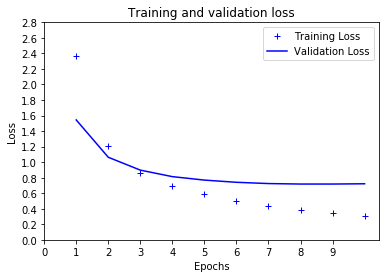

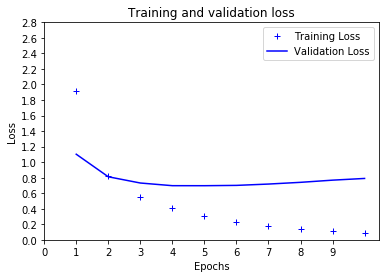

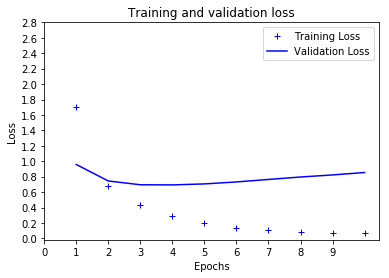

In [75]:
chart_loss(history_embed_small)
chart_loss(history_embed_medium)
chart_loss(history_embed_large)

We can see how the model with larger embedding size tend to overfit faster than the others (respectively epochs 2, 3, and 4). However, from a loss point of view all the models starts overfitting with a loss values ~ 0.8.
Let's now analyze values for accuracy.

In [76]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss)    

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch]

In [77]:
print('min loss for model small is {}'.format(min_loss(history_embed_small)))
print('min loss for model medium is {}'.format(min_loss(history_embed_medium)))
print('min loss for model large is {}'.format(min_loss(history_embed_large)))

min loss for model small is 7
min loss for model medium is 4
min loss for model large is 3


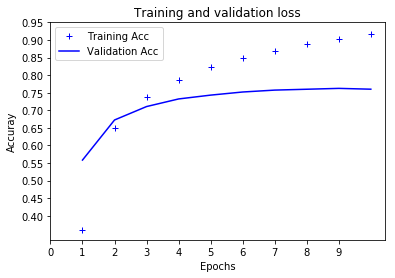

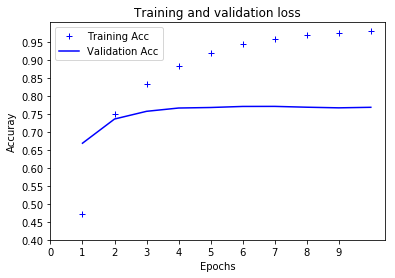

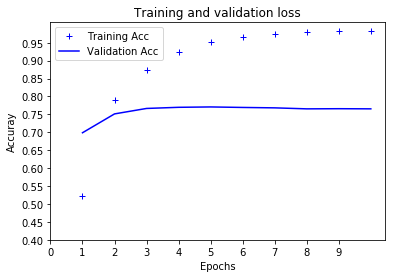

In [78]:
chart_acc(history_embed_small)
chart_acc(history_embed_medium)
chart_acc(history_embed_large)

In [79]:
print('best validation accuracy for model small is {}'.format(
    accuracy(history_embed_small, min_loss(history_embed_small))))
print('best validation accuracy for model medium is {}'.format(
    accuracy(history_embed_medium, min_loss(history_embed_medium))))
print('best validation accuracy for model large is {}'.format(
    accuracy(history_embed_large, min_loss(history_embed_large))))

best validation accuracy for model small is 0.7598542001900799
best validation accuracy for model medium is 0.7673984911620259
best validation accuracy for model large is 0.7696448249201295


The results show how only using an flat classifier with an embedding layer we obtain an accuracy ~ 77%. Which is a pretty good result.
The next steps is use an embedding layers in a Feed Forward Neural Network.

## Build the Models

We take into account:
- a base model that uses dropout
- a embed model that adds an embedding layer

In [80]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [111]:
def build_model_embeddings(neurons, embed_size):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_features, output_dim=embed_size, input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    model.compile(optimizer=optimizers.Adam(), 
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    return model

In [114]:
model_dropout = build_model_dropout(256)

In [115]:
history_dropout = model_dropout.fit(x=x_train, y=y_train,  validation_split=0.2,
                   epochs=10, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/10
94376/94376 [==============================] - 5s 56us/step - loss: 1.6908 - acc: 0.4951 - val_loss: 0.8161 - val_acc: 0.7343
Epoch 2/10
94376/94376 [==============================] - 5s 48us/step - loss: 0.8660 - acc: 0.7149 - val_loss: 0.6786 - val_acc: 0.7680
Epoch 3/10
94376/94376 [==============================] - 5s 48us/step - loss: 0.6838 - acc: 0.7682 - val_loss: 0.6333 - val_acc: 0.7839
Epoch 4/10
94376/94376 [==============================] - 4s 48us/step - loss: 0.5762 - acc: 0.8034 - val_loss: 0.6245 - val_acc: 0.7893
Epoch 5/10
94376/94376 [==============================] - 5s 49us/step - loss: 0.5109 - acc: 0.8257 - val_loss: 0.6059 - val_acc: 0.7963
Epoch 6/10
94376/94376 [==============================] - 5s 49us/step - loss: 0.4529 - acc: 0.8438 - val_loss: 0.6186 - val_acc: 0.7984
Epoch 7/10
94376/94376 [==============================] - 4s 48us/step - loss: 0.4129 - acc: 0.8573 - val_loss: 0.6127 - val_acc

In [116]:
model_embed = build_model_embeddings(256,256)

In [117]:
history_embed = model_embed.fit(x=x_train_seq, y=y_train,  validation_split=0.2,
                   epochs=10, batch_size=256)

Train on 94376 samples, validate on 23594 samples
Epoch 1/10
94376/94376 [==============================] - 11s 116us/step - loss: 1.9792 - acc: 0.4145 - val_loss: 0.9469 - val_acc: 0.6964
Epoch 2/10
94376/94376 [==============================] - 10s 109us/step - loss: 0.8240 - acc: 0.7316 - val_loss: 0.7747 - val_acc: 0.7437
Epoch 3/10
94376/94376 [==============================] - 10s 110us/step - loss: 0.5282 - acc: 0.8223 - val_loss: 0.7945 - val_acc: 0.7495
Epoch 4/10
94376/94376 [==============================] - 10s 111us/step - loss: 0.3698 - acc: 0.8737 - val_loss: 0.8549 - val_acc: 0.7515
Epoch 5/10
94376/94376 [==============================] - 11s 111us/step - loss: 0.2834 - acc: 0.9055 - val_loss: 0.9662 - val_acc: 0.7498
Epoch 6/10
94376/94376 [==============================] - 11s 113us/step - loss: 0.2259 - acc: 0.9233 - val_loss: 1.0691 - val_acc: 0.7468
Epoch 7/10
94376/94376 [==============================] - 11s 112us/step - loss: 0.1905 - acc: 0.9364 - val_loss: 1.

### Printing The Loss

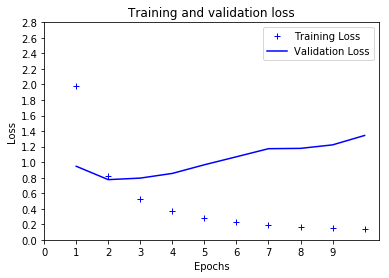

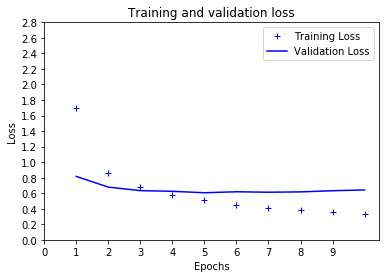

In [118]:
chart_loss(history_embed)
chart_loss(history_dropout)

From the charts we can see that: 
- word embedding seems to not improve the accuracy of the model. This is usual in the case you have little training data available. From another point of view it is surprising to see that the classifier with only an embedding layer perform better than the one taken into account here
- the model with dropout perform better than the model with embeddings.

From this result one could gather that embeddings are not useful. This is wrong, because we didn't consider that we changed another thing with the current represantion. The model that uses embedding takes as input sequence of ids and not a vectorize representation of subjects. 

In the next post we will explore the usage of LSTM to address this kind of representation. 

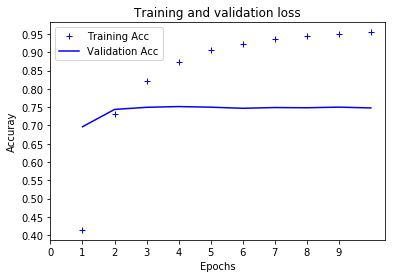

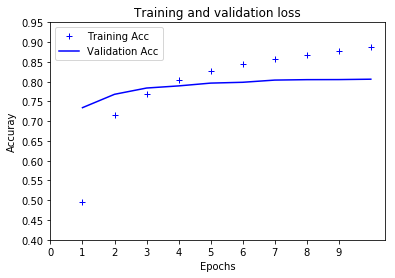

In [119]:
chart_acc(history_embed)
chart_acc(history_dropout)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [120]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

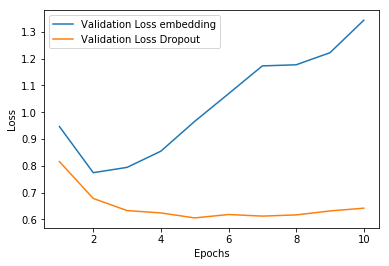

In [121]:
compare_loss({'embedding': history_embed, 'Dropout': history_dropout})

In [122]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

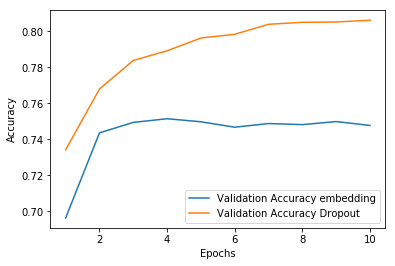

In [123]:
compare_accuracy({'embedding': history_embed, 'Dropout': history_dropout})

### Evaluate on the Test Set

We still want to evaluate the models with embedding to understand if it overfits on input data.

In [133]:
model = build_model_embeddings(256,256)

In [134]:
history = model.fit(x=x_train_seq, y=y_train, epochs=2, batch_size=256)

Epoch 1/2
117970/117970 [==============================] - 13s 113us/step - loss: 1.7733 - acc: 0.4710
Epoch 2/2
117970/117970 [==============================] - 13s 106us/step - loss: 0.7558 - acc: 0.7511


In [135]:
loss, acc = model.evaluate(x_test_seq, y_test)

29493/29493 [==============================] - 2s 59us/step


In [136]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.715640866418532
acc 0.7621130437811826


## Conclusion

We evaluated how to use Embeddings as alternative to one-hot encoding. 
